In [6]:
import pandas as pd
from communitygraph.bipartite import BipartiteCommunity as bp
from communitygraph import util
from collections import Counter
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
import seaborn as sns
sns.set(style='darkgrid')

# Config Variables

In [418]:
PATH = os.path.join(os.getcwd(), 'raw_data/100k_a.csv')
USER_KEY = 'user_id'
STREAM_ID_KEY = 'stream_id'
ITEM_KEY = 'streamer_name'
START_KEY = 'start_time'
END_KEY = 'stop_time'

# This should have been generated using part1's notebook (at the end)
PARTITION_PATH = os.path.join(os.getcwd(), 'saved_communities', 'part100.pickle')

# DATASET LOAD: Applying our optimal partition

In the previous notebook, we found a good min_item_degree to filter out nodes by.

The purpose was two-fold: to reduce our item recommendation space, and to ensure a high quality partition so that we could use the communities as a diversity metric

In this notebook, we filter out by min_item_degree, as well as users with < 10 interactions using the new set of items

In [429]:
df = pd.read_csv(PATH, names=[USER_KEY, STREAM_ID_KEY, ITEM_KEY, START_KEY, END_KEY])

In [430]:
with open(PARTITION_PATH, 'rb') as f:
    part100 = pickle.load(f)
df = util.label_df_partition(df, 'streamer_name', part100)

In [431]:
# save for plotting
original_df = df

# Filter out users with < 10 interactions

In [432]:
user_counts = {k:v for k,v in Counter(df[USER_KEY]).items() if v >= 10}

In [433]:
df = df[df[USER_KEY].isin(user_counts)]

# Sample for Final Dataset

Our dataset is still a bit too large to train our recommendation system in reasonable time and run all the experiments we will need.

Thus, we will randomly sample a subset of users.

We have two methods:
 - Weighted sample according to user interaction count
 - Unweighted sample (where every user has equal probability)

In [434]:
# normalize
total_interactions = sum(user_counts.values())
for user, val in user_counts.items():
    user_counts[user] = val / total_interactions

In [435]:
user_sample = set(np.random.choice(list(user_counts.keys()), size=2000, replace=False, p=list(user_counts.values())))

In [436]:
# user_sample = set(np.random.choice(list(user_counts.keys()), size=3500, replace=False))

In [437]:
df = df[df[USER_KEY].isin(user_sample)]

In [438]:
len(df)

105745

# Lets verify that our sample makes sense, by comparing to the original partition

In [439]:
def plot_helper(counts, title=None) -> plt.Figure:
    """Plots a histogram from counts dict"""
    fig = plt.figure()

    # Creating the barplot
    plt.bar(counts.keys(), counts.values())
    plt.xlabel("Community ID")
    plt.ylabel("Size")
    
#     plt.title(title or "Partition Distribution")
    plt.title(title)
    plt.show()

In [440]:
dataset_community_counts = Counter(original_df['community'])

In [441]:
sample_community_counts = Counter(df['community'])

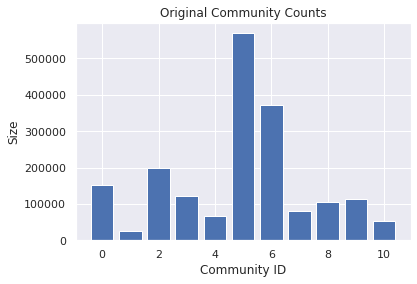

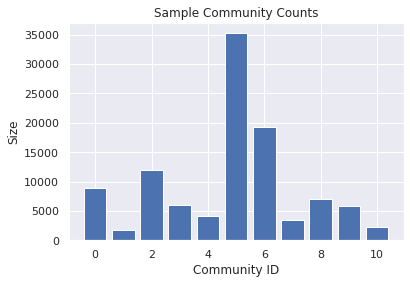

In [442]:
plot_helper(dataset_community_counts, title="Original Community Counts")
plot_helper(sample_community_counts, title="Sample Community Counts")

# Final Preprocessing Steps
We run the following final preprocessing steps:
- Label the interactions with the community of the item (completed)
- Convert the streamer names to ints
- Strip unnecessary columns
- Save this new dataset to the processed_data folder

In [443]:
df = df[['user_id', 'streamer_name', 'start_time', 'community']]

In [444]:
df['streamer_name'] = pd.Categorical(df['streamer_name'], categories=df['streamer_name'].unique()).codes

In [445]:
df.head()

,user_id,streamer_name,start_time,community
1093,43,0,93,8
1094,43,1,281,8
1098,43,2,281,5
1099,43,3,281,5
1101,43,0,379,8


# Statistics and Saving Processed Dataset

In [449]:
print(f"# of users: {len(set(df[USER_KEY]))}")
print(f"# of streamers: {len(set(df[ITEM_KEY]))}")
print(f"# of interactions per user: {len(df)/len(set(df[USER_KEY]))}")
print(f"# of unique interactions per user: {len(set(zip(df[USER_KEY], df[ITEM_KEY])))/len(set(df[USER_KEY]))}")

# of users: 2000
# of streamers: 1742
# of interactions per user: 52.8725
# of unique interactions per user: 19.062


In [456]:
print(f"# of unique interactions per item: {len(set(zip(df[USER_KEY], df[ITEM_KEY])))/len(set(df[ITEM_KEY]))}")

# of unique interactions per item: 21.88518943742824


In [457]:
print(f"Average edge weight: {len(df) / len(set(zip(df[USER_KEY], df[ITEM_KEY])))}")

Average edge weight: 2.7737120973664884


# Saving Processed Dataset

In [453]:
SAVE_PATH = os.path.join(os.getcwd(), 'processed_data/twitch105k.csv')

In [454]:
df.to_csv(SAVE_PATH)